# Restricted Boltzmann Machine - MNIST

- Plot log likelihood for different values of the hidden layers L
- Plot final loglikelihood for different gammas, for understand how much regularization is better (it shouldn't go down)
- Plot for the configuration of optimum parameters the comparison between the two GD methods
- Graphic for learning rates for a given GD method, lkl per epoch
- Good plot for current version final log-likelihood and in x axis the specific configuration (maybe it's more visible and usefull)
- Model for different numbers, for show that some tasks are easier than others, per epoch and final log-likelihood for each combination of numbers
- Plot log-likelihood for different steps



## Imports

In [1]:
import sys, datetime
import os

import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml


os.makedirs("FIG/FRAME", exist_ok=True)
os.makedirs("WEIGHTS", exist_ok=True)
os.makedirs("DATA", exist_ok=True)

## Load data

In [3]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [5]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    Nz=L
else:
    str_simul="RBM"
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


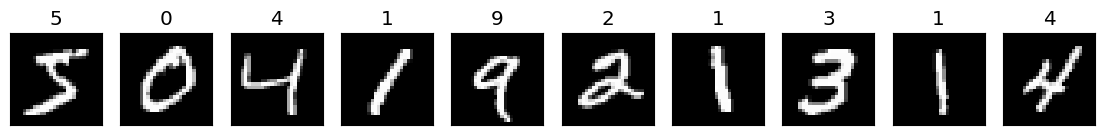

first 10 MNIST-3 data points


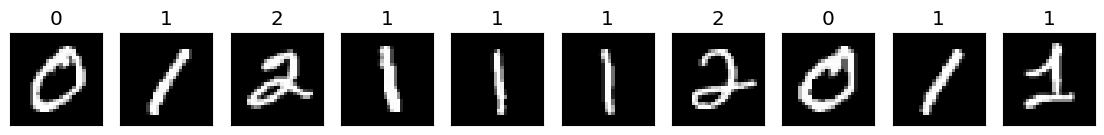

first 10 MNIST-3 data points, binarized


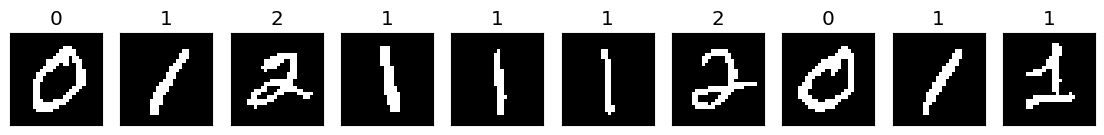

each of Nd=21770 data has D=784 bits


In [7]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

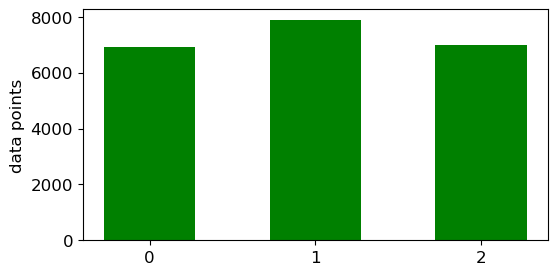

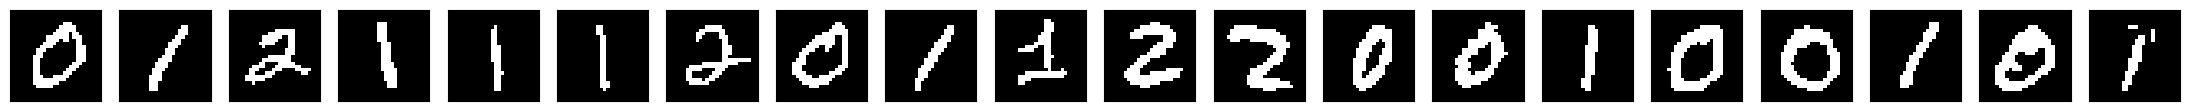

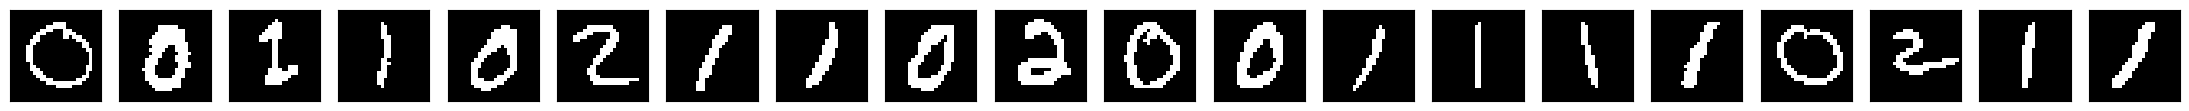

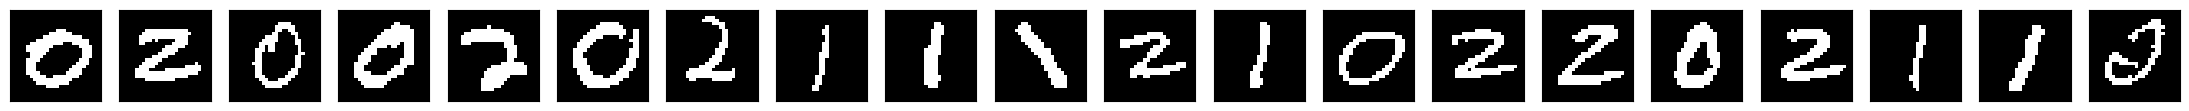

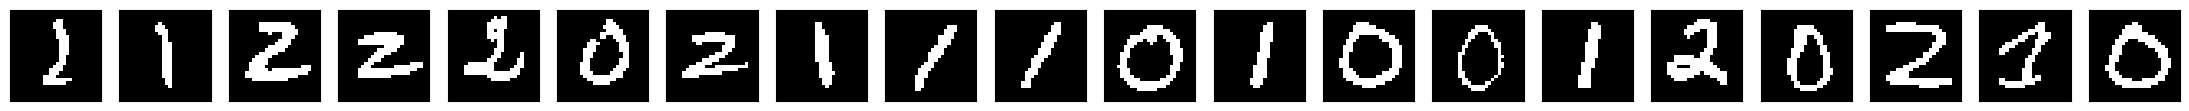

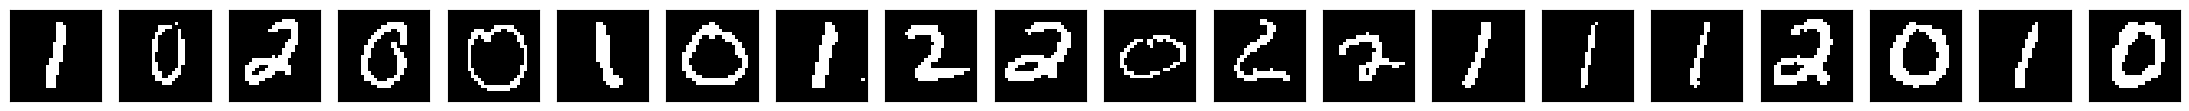

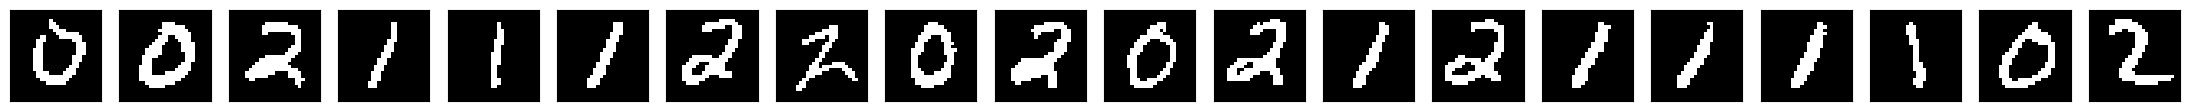

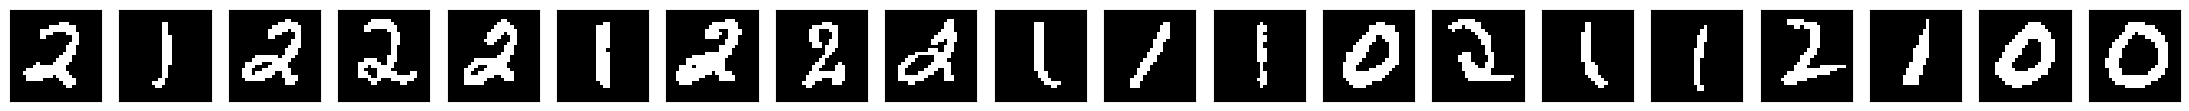

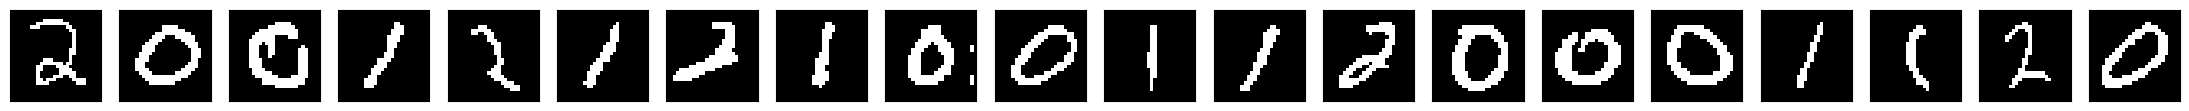

In [9]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [11]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [13]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [15]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

# RBM train


In [17]:
def RBM_train(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini=None, l_rate_fin=None):
    np.random.seed(12345)
    
    w = sigma * np.random.randn(D,L)
    a = Hinton_bias_init(data)
    b = np.zeros(L)
    
    if GRAD == "SGD":
        if l_rate_ini is None: l_rate_ini = 1.0
        if l_rate_fin is None: l_rate_fin = 0.25
    elif GRAD == "RMSprop":
        beta, epsilon = 0.9, 1e-4
        if l_rate_ini is None: l_rate_ini = 0.05
        if l_rate_fin is None: l_rate_fin = 0.05
        print("epsilon=", epsilon)
    
    print(f"D={D}\tsample size\nL={L}\tnr. z states")
    print("Gradient descent type:", GRAD)
    print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
    if gamma != 0: print(f"gamma={gamma}\tregularization")
    
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    Nt = steps
    
    wE, aE, bE = np.zeros((Nepoch+1, D, L)), np.zeros((Nepoch+1, D)), np.zeros((Nepoch+1, L))
    wE[0], aE[0], bE[0] = np.copy(w), np.copy(a), np.copy(b)
    if GRAD == "RMSprop":
        gw2, ga2, gb2 = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)
    
    print("Starting the training")
    
    for epoch in range(1, 1 + Nepoch):
        q = (epoch-1.) / (Nepoch-1.)
        l_rate = l_rate_ini + (l_rate_fin - l_rate_ini) * q
    
        for mini in range(Nmini):
            x_data, x_model = np.zeros(D), np.zeros(D)
            z_data, z_model = np.zeros(L), np.zeros(L)
            xz_data, xz_model = np.zeros((D,L)), np.zeros((D,L))
            
            selected = np.random.choice(np.arange(Nd).astype("int"), int(10 + (500-10) * (q**2)), replace=False)
            for k in selected:
                x0 = data[k]
                z = CD_step(x0, w, b)
                x_data += x0
                z_data += z
                xz_data += np.outer(x0, z)
                
                zf = np.copy(z)
                for t in range(Nt):
                    xf = CD_step(zf, w.T, a)
                    zf = CD_step(xf, w, b)
                x_model += xf
                z_model += zf
                xz_model += np.outer(xf, zf)
            
            gw, ga, gb = (xz_data-xz_model)/len(selected), (x_data-x_model)/len(selected), (z_data-z_model)/len(selected)
    
            if GRAD == "RMSprop":
                gw2 = beta * gw2 + (1 - beta) * np.square(gw)
                ga2 = beta * ga2 + (1 - beta) * np.square(ga)
                gb2 = beta * gb2 + (1 - beta) * np.square(gb)
                w += l_rate * gw / np.sqrt(epsilon + gw2)
                a += l_rate * ga / np.sqrt(epsilon + ga2)
                b += l_rate * gb / np.sqrt(epsilon + gb2)
            else:
                w += l_rate * gw
                a += l_rate * ga
                b += l_rate * gb
    
            if gamma > 0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch], aE[epoch], bE[epoch] = np.copy(w), np.copy(a), np.copy(b)
        print(f"epoch {epoch}/{Nepoch} rate: {l_rate} gam: {gamma}")
    
    print("END of learning phase")
    return wE, aE, bE

## Log-likelihood function

In [19]:
def lkl(data, w, a, b, Nd, L, binary=True, chunk_size=16384):
    if not binary:
        raise NotImplementedError("Spin version not implemented")
    
    # Use the vectorized version for small L values
    if L <= 14:
        # Create the z matrix with all 2^L binary configurations: shape (M_z, L)
        z_mat = np.array(list(itertools.product([0, 1], repeat=L)))
        
        # Compute H for each configuration: H(z) = a + W*z.
        # a: (D,), w: (D, L), each z in z_mat: (L,), result: (M_z, D)
        H_mat = a[None, :] + np.dot(z_mat, w.T)
        
        # Compute G for each configuration: G(z) = exp(z dot b), result: (M_z,)
        G = np.exp(np.dot(z_mat, b))
        
        # Compute the partition function sum over z: ∏_{i}(1+exp(H_i(z)))
        z_sum = np.sum(G * np.prod(1 + np.exp(H_mat), axis=1))
        
        # log partition term (q is assumed to be 1)
        log_part = np.log(z_sum + 1e-14)
        
        # Compute energy for each data point: sum_{z} G(z)*exp(dot(H(z),x))
        energies = np.dot(np.exp(np.dot(data, H_mat.T)), G)
        
        log_likelihood = np.mean(np.log(energies) - log_part)
        return log_likelihood
    
    # Use the chunked (merged) version for large L values
    else:
        total_configs = 2 ** L
        partition_sum = 0.0
        N = data.shape[0]
        energies = np.zeros(N)
        
        for start in range(0, total_configs, chunk_size):
            end = min(start + chunk_size, total_configs)
            # Generate chunk of z configurations: shape (chunk_size, L)
            z_chunk = np.array([list(np.binary_repr(x, width=L)) for x in range(start, end)], dtype=np.int8)
            
            # Compute H for the chunk: H(z) = a + W*z, shape: (chunk, D)
            H_chunk = a[None, :] + np.dot(z_chunk, w.T)
            
            # Compute G for the chunk: G(z) = exp(z dot b), shape: (chunk,)
            G_chunk = np.exp(np.dot(z_chunk, b))
            
            # Accumulate partition function: product over i of (1 + exp(H_i(z)))
            prod_chunk = np.prod(1 + np.exp(H_chunk), axis=1)
            partition_sum += np.sum(G_chunk * prod_chunk)
            
            # Compute energy contributions: for each data point, add sum_{z in chunk} G(z)*exp(dot(H(z),x))
            energies += np.dot(np.exp(np.dot(data, H_chunk.T)), G_chunk)
        
        log_part = np.log(partition_sum + 1e-14)
        log_likelihood = np.mean(np.log(energies) - log_part)
        return log_likelihood

## Final log-likelihood for different configurations of hyperparameters

In [63]:
import numpy as np
import itertools
from tabulate import tabulate


def test_hyperparameters(steps, Nepoch, Nmini, plot, gammas, grad_types, data):
    results = []
    
    learning_rates_sgd = [(1.0, 0.25), (0.5, 0.1), (0.1, 0.01)]
    learning_rates_rmsprop = [(0.05, 0.05), (0.075, 0.075), (0.01, 0.01)]
    
    for GRAD in grad_types:
        for gamma in gammas:
            if GRAD == "SGD":
                learning_rates = learning_rates_sgd
            elif GRAD == "RMSprop":
                learning_rates = learning_rates_rmsprop
            
            for l_rate_ini, l_rate_fin in learning_rates:
                wE, aE, bE = RBM_train(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini, l_rate_fin)
                log_likelihood = lkl(data, wE[-1], aE[-1], bE[-1], len(data), L=3, binary=True)
                
                results.append({
                    'gradient_type': GRAD,
                    'l_rate_ini': l_rate_ini,
                    'l_rate_fin': l_rate_fin,
                    'gamma': gamma,
                    'log_likelihood': log_likelihood
                })
    
    
    headers = ["Gradient Type", "LR Initial", "LR Final", "Gamma", "Log-Likelihood"]
    table_data = [[r['gradient_type'], r['l_rate_ini'], r['l_rate_fin'], r['gamma'], r['log_likelihood']] for r in results]
    print(tabulate(table_data, headers=headers, floatfmt=".6f"))
    
    
    best_config = max(results, key=lambda x: x['log_likelihood'])
    print("\nBest Hyperparameter Configuration:")
    print(f"Gradient Type: {best_config['gradient_type']}")
    print(f"LR Initial: {best_config['l_rate_ini']}")
    print(f"LR Final: {best_config['l_rate_fin']}")
    print(f"Gamma: {best_config['gamma']}")
    print(f"Max Log-Likelihood: {best_config['log_likelihood']:.6f}")
    
    return results, best_config


In [67]:
gammas = [0, 0.001, 0.01]  
grad_types = ["SGD", "RMSprop"] 

results, best_config = test_hyperparameters(steps=5, Nepoch=150, Nmini=3, plot=False, gammas=gammas, grad_types=grad_types, data=data)

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
Nepoch=150
Nmini=3
Starting the training
epoch 1/150 rate: 1.0 gam: 0
epoch 2/150 rate: 0.9949664429530202 gam: 0
epoch 3/150 rate: 0.9899328859060402 gam: 0
epoch 4/150 rate: 0.9848993288590604 gam: 0
epoch 5/150 rate: 0.9798657718120806 gam: 0
epoch 6/150 rate: 0.9748322147651006 gam: 0
epoch 7/150 rate: 0.9697986577181208 gam: 0
epoch 8/150 rate: 0.964765100671141 gam: 0
epoch 9/150 rate: 0.9597315436241611 gam: 0
epoch 10/150 rate: 0.9546979865771812 gam: 0
epoch 11/150 rate: 0.9496644295302014 gam: 0
epoch 12/150 rate: 0.9446308724832215 gam: 0
epoch 13/150 rate: 0.9395973154362416 gam: 0
epoch 14/150 rate: 0.9345637583892618 gam: 0
epoch 15/150 rate: 0.9295302013422819 gam: 0
epoch 16/150 rate: 0.924496644295302 gam: 0
epoch 17/150 rate: 0.9194630872483222 gam: 0
epoch 18/150 rate: 0.9144295302013423 gam: 0
epoch 19/150 rate: 0.9093959731543624 gam: 0
epoch 20/150 rate: 0.90436241610

In [115]:
def plot_hyperparameter_results(results, filename = "Hyperparameters_Results.pdf"):
    
    log_likelihoods = [r['log_likelihood'] for r in results]
    labels = [f"{r['gradient_type']}\nLR: {r['l_rate_ini']}-{r['l_rate_fin']}\nGamma: {r['gamma']}" for r in results]
    
    
    plt.figure(figsize=(14, 7))
    plt.scatter(range(len(results)), log_likelihoods, color='b', label="Final Log-Likelihood")
    plt.plot(range(len(results)), log_likelihoods, linestyle="--", color='gray', alpha=0.7)
    
    
    plt.xticks(range(len(results)), labels, rotation=45, ha='right', fontsize=10)
    plt.xlabel("Hyperparameter Configuration")
    plt.ylabel("Final Log-Likelihood")
    plt.title("Hyperparameter Optimization Results")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    
    
    plt.tight_layout()
    plt.savefig(filename, format="pdf")

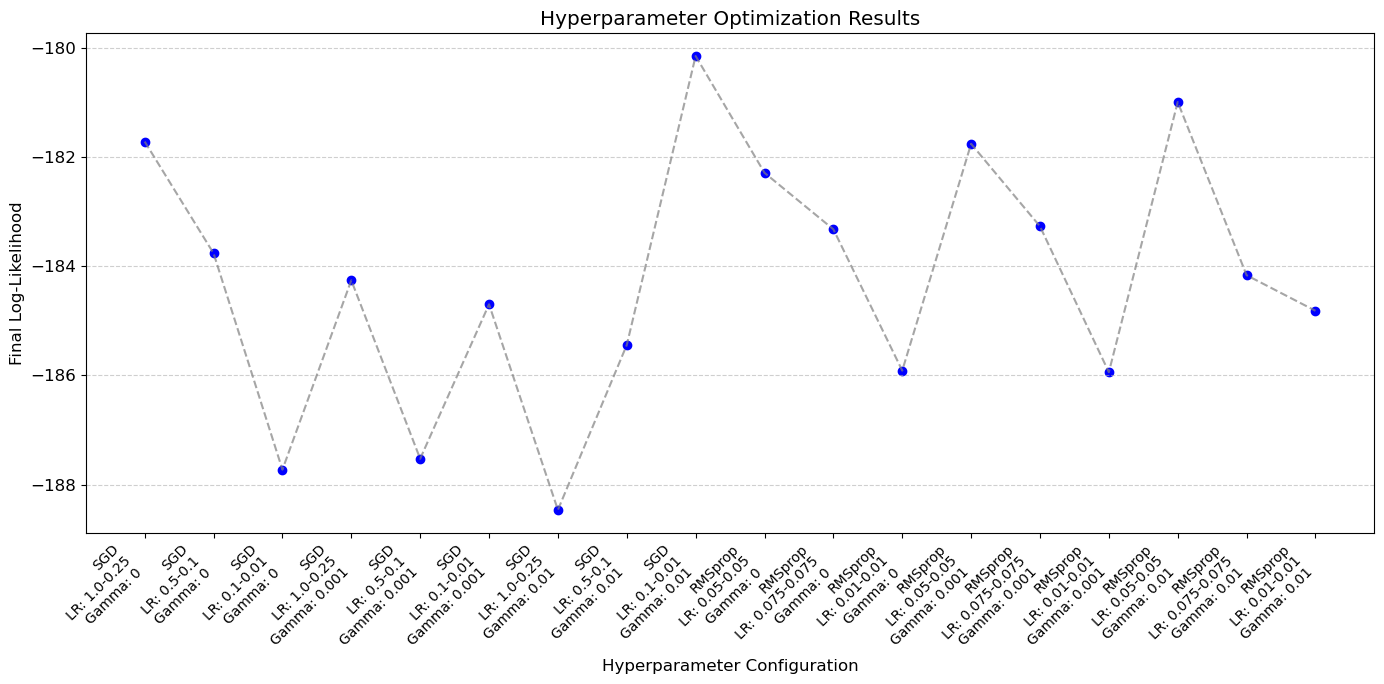

In [119]:
plot_hyperparameter_results(results, filename = "Hyperparameters_Results.pdf")

## Best configuration depending on gamma values

In [31]:
def evaluate_gamma_results(steps, Nepoch, Nmini, gammas, best_config, data):
    log_likelihoods = []
    
   
    GRAD = best_config['gradient_type']
    l_rate_ini = best_config['l_rate_ini']
    l_rate_fin = best_config['l_rate_fin']

    
    for gamma in gammas:
        wE, aE, bE = RBM_train(steps, Nepoch, Nmini, False, GRAD, gamma, l_rate_ini, l_rate_fin)
        log_likelihood = lkl(data, wE[-1], aE[-1], bE[-1], len(data), L=3, binary=True)
        log_likelihoods.append(log_likelihood)

    
    return list(zip(gammas, log_likelihoods))



In [89]:
gammas = [0, 0.0001, 0.001, 0.01, 0.1]
results_gamma = evaluate_gamma_results(steps=5, Nepoch=100, Nmini=3, gammas=gammas, best_config=best_config, data=data)

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 0.1 --> 0.01
Nepoch=100
Nmini=3
Starting the training
epoch 1/100 rate: 0.1 gam: 0
epoch 2/100 rate: 0.09909090909090909 gam: 0
epoch 3/100 rate: 0.09818181818181819 gam: 0
epoch 4/100 rate: 0.09727272727272727 gam: 0
epoch 5/100 rate: 0.09636363636363637 gam: 0
epoch 6/100 rate: 0.09545454545454546 gam: 0
epoch 7/100 rate: 0.09454545454545454 gam: 0
epoch 8/100 rate: 0.09363636363636364 gam: 0
epoch 9/100 rate: 0.09272727272727273 gam: 0
epoch 10/100 rate: 0.09181818181818183 gam: 0
epoch 11/100 rate: 0.09090909090909091 gam: 0
epoch 12/100 rate: 0.09000000000000001 gam: 0
epoch 13/100 rate: 0.0890909090909091 gam: 0
epoch 14/100 rate: 0.08818181818181818 gam: 0
epoch 15/100 rate: 0.08727272727272728 gam: 0
epoch 16/100 rate: 0.08636363636363636 gam: 0
epoch 17/100 rate: 0.08545454545454545 gam: 0
epoch 18/100 rate: 0.08454545454545455 gam: 0
epoch 19/100 rate: 0.08363636363636365 gam: 0
epoch 20/100 

In [121]:
from matplotlib.ticker import ScalarFormatter

def plot_gamma_effect(gammas, log_likelihoods, filename = "Gamma_Effect.pdf"):
    plt.figure(figsize=(8, 5))
    plt.plot(gammas, log_likelihoods, marker='o', linestyle='-', color='b')

    
    plt.xscale('log')

    
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    plt.xlabel("Gamma")
    plt.ylabel("Final Log-Likelihood")
    plt.title("Effect of Gamma on Log-Likelihood")
    plt.grid(True, which="both", ls="--")
    plt.savefig(filename, format="pdf")

    plt.show()

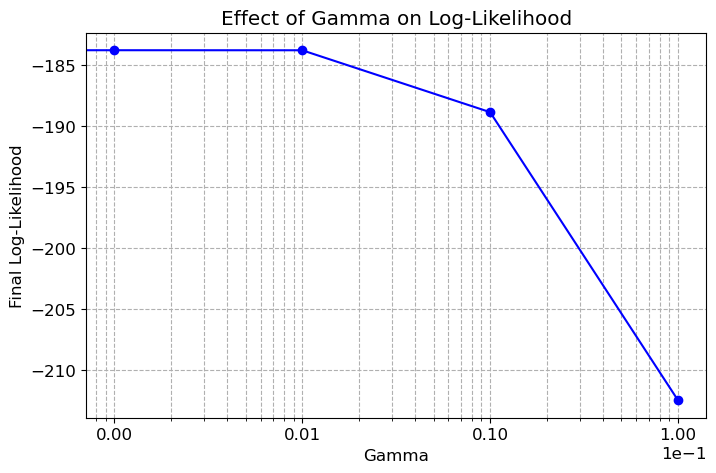

In [123]:
gammas, log_likelihoods = zip(*results_gamma)  
plot_gamma_effect(gammas, log_likelihoods, filename = "Gamma_Effect.pdf")

## Values of log-likelihood per epoch for different hyperparameters

In [125]:
def train_and_log_likelihood(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini, l_rate_fin, data):
    """Trains the RBM and computes log-likelihood at each epoch."""
    log_likelihoods = []
    
    
    wE, aE, bE = RBM_train(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini, l_rate_fin)
    
    for epoch in range(Nepoch + 1):    
        log_likelihood = lkl(data, wE[epoch], aE[epoch], bE[epoch], len(data), L = 3, binary=True)
        log_likelihoods.append(log_likelihood)
    
    return log_likelihoods


def compute_log_likelihoods(steps, Nepoch, Nmini, plot, gammas, grad_types, data):
    """Computes and stores log-likelihood results for each parameter combination."""
    results = {}
    
    learning_rates_sgd = [(1.0, 0.25), (0.5, 0.1), (0.1, 0.01)]
    learning_rates_rmsprop = [(0.05, 0.05), (0.075, 0.075), (0.01, 0.01)]
    
    for GRAD in grad_types:
        for gamma in gammas:
            if GRAD == "SGD":
                learning_rates = learning_rates_sgd
            elif GRAD == "RMSprop":
                learning_rates = learning_rates_rmsprop
            
            for l_rate_ini, l_rate_fin in learning_rates:
                key = (GRAD, gamma, l_rate_ini, l_rate_fin)
                log_likelihoods = train_and_log_likelihood(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini, l_rate_fin, data)
                results[key] = log_likelihoods
    
    return results

In [127]:
steps = 5  
Nepoch = 150  
Nmini = 10  
plot = False  
gammas = [0, 0.001, 0.01]   
grad_types = ["SGD", "RMSprop"] 


In [129]:
results_per_epoch = compute_log_likelihoods(steps, Nepoch, Nmini, plot, gammas, grad_types, data)

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
Nepoch=150
Nmini=10
Starting the training
epoch 1/150 rate: 1.0 gam: 0
epoch 2/150 rate: 0.9949664429530202 gam: 0
epoch 3/150 rate: 0.9899328859060402 gam: 0
epoch 4/150 rate: 0.9848993288590604 gam: 0
epoch 5/150 rate: 0.9798657718120806 gam: 0
epoch 6/150 rate: 0.9748322147651006 gam: 0
epoch 7/150 rate: 0.9697986577181208 gam: 0
epoch 8/150 rate: 0.964765100671141 gam: 0
epoch 9/150 rate: 0.9597315436241611 gam: 0
epoch 10/150 rate: 0.9546979865771812 gam: 0
epoch 11/150 rate: 0.9496644295302014 gam: 0
epoch 12/150 rate: 0.9446308724832215 gam: 0
epoch 13/150 rate: 0.9395973154362416 gam: 0
epoch 14/150 rate: 0.9345637583892618 gam: 0
epoch 15/150 rate: 0.9295302013422819 gam: 0
epoch 16/150 rate: 0.924496644295302 gam: 0
epoch 17/150 rate: 0.9194630872483222 gam: 0
epoch 18/150 rate: 0.9144295302013423 gam: 0
epoch 19/150 rate: 0.9093959731543624 gam: 0
epoch 20/150 rate: 0.9043624161

In [138]:
steps = 5  
Nepoch = 150  
Nmini = 10  
plot = False  
gammas = [0.01]   
grad_types = ["SGD", "RMSprop"]  

In [140]:
results_comprative_GD = compute_log_likelihoods(steps, Nepoch, Nmini, plot, gammas, grad_types, data)

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
gamma=0.01	regularization
Nepoch=150
Nmini=10
Starting the training
epoch 1/150 rate: 1.0 gam: 0.01
epoch 2/150 rate: 0.9949664429530202 gam: 0.01
epoch 3/150 rate: 0.9899328859060402 gam: 0.01
epoch 4/150 rate: 0.9848993288590604 gam: 0.01
epoch 5/150 rate: 0.9798657718120806 gam: 0.01
epoch 6/150 rate: 0.9748322147651006 gam: 0.01
epoch 7/150 rate: 0.9697986577181208 gam: 0.01
epoch 8/150 rate: 0.964765100671141 gam: 0.01
epoch 9/150 rate: 0.9597315436241611 gam: 0.01
epoch 10/150 rate: 0.9546979865771812 gam: 0.01
epoch 11/150 rate: 0.9496644295302014 gam: 0.01
epoch 12/150 rate: 0.9446308724832215 gam: 0.01
epoch 13/150 rate: 0.9395973154362416 gam: 0.01
epoch 14/150 rate: 0.9345637583892618 gam: 0.01
epoch 15/150 rate: 0.9295302013422819 gam: 0.01
epoch 16/150 rate: 0.924496644295302 gam: 0.01
epoch 17/150 rate: 0.9194630872483222 gam: 0.01
epoch 18/150 rate: 0.9144295302013423 gam: 0

In [162]:
import matplotlib.pyplot as plt

def plot_log_likelihoods(results, filename="log_likelihood_comparative.pdf"): 
    """Plots the log-likelihood per epoch for different gradient descent methods and saves it to a PDF."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']

    grad_methods = ["SGD", "RMSprop"]
    
    for i, GRAD in enumerate(grad_methods):
        ax = axes[i]
        color_idx = 0

        for (grad, gamma, l_rate_ini, l_rate_fin), log_likelihoods in results.items():
            if grad == GRAD:
                label = f"γ={gamma}, LR={l_rate_ini}->{l_rate_fin}"
                ax.plot(log_likelihoods, label=label, color=colors[color_idx % len(colors)])
                color_idx += 1
        
        ax.set_title(f"Log-Likelihood per Epoch ({GRAD})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Log-Likelihood")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.savefig(filename, format="pdf") 

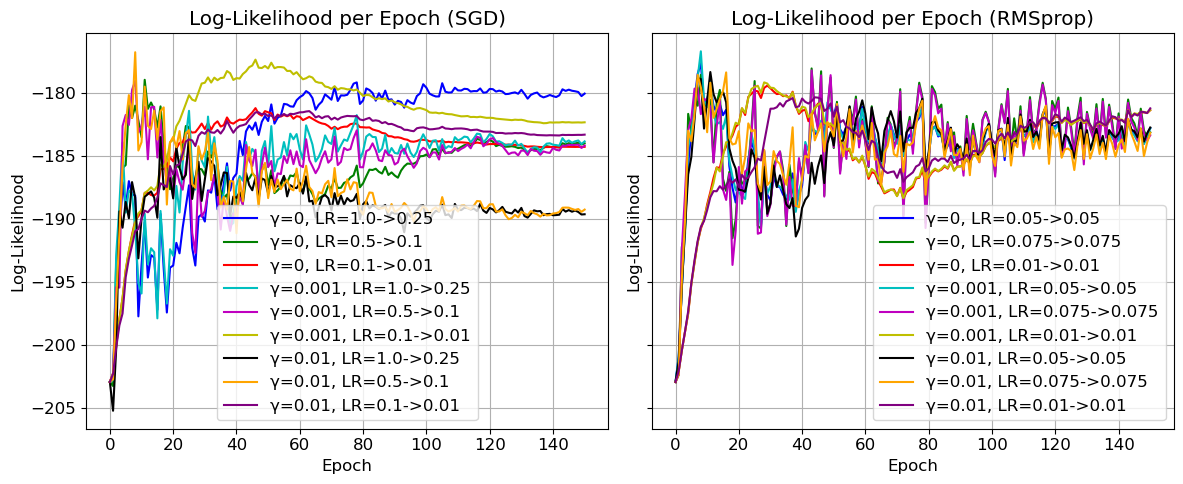

In [136]:
plot_log_likelihoods(results_per_epoch)

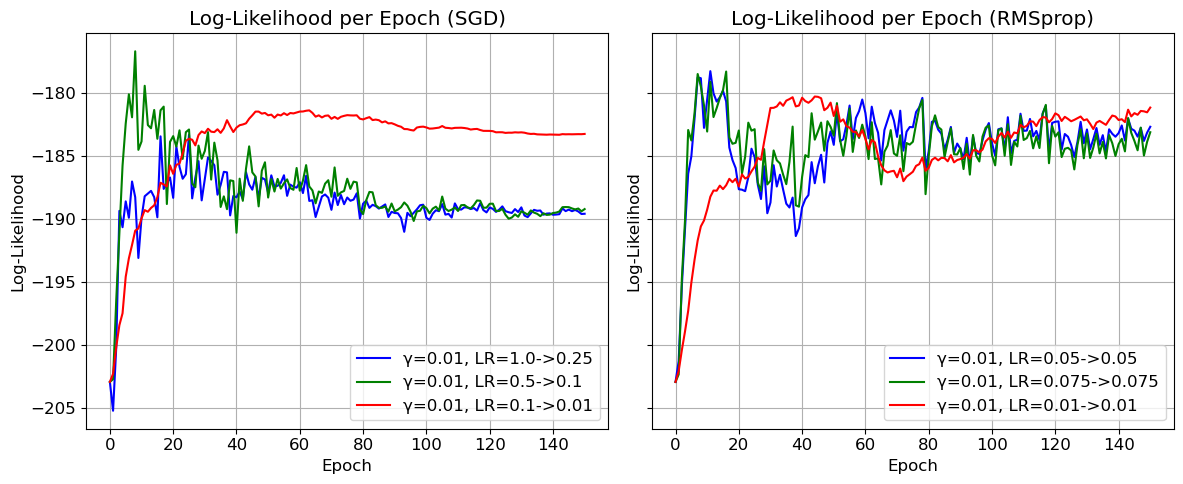

In [164]:
plot_log_likelihoods(results_comprative_GD)

## Log-likelihoods per epoch for different steps values

In [144]:
def compute_log_likelihoods_steps(steps_values, Nepoch, Nmini, plot, best_config, data):
    """Computes log-likelihood per epoch for different values of steps."""
    log_likelihoods_per_step = {}

    
    GRAD = best_config['gradient_type']
    gamma = best_config['gamma']
    l_rate_ini = best_config['l_rate_ini']
    l_rate_fin = best_config['l_rate_fin']


    for steps in steps_values:
        log_likelihoods = train_and_log_likelihood(steps, Nepoch, Nmini, plot, GRAD, gamma, l_rate_ini, l_rate_fin, data)
        log_likelihoods_per_step[steps] = log_likelihoods

    return log_likelihoods_per_step

In [156]:
steps_values = [1, 3, 5, 7, 9, 11, 13]


log_likelihoods_per_step = compute_log_likelihoods_steps(steps_values, Nepoch=150, Nmini=3, plot=True, best_config=best_config, data=data)

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 0.1 --> 0.01
gamma=0.01	regularization
Nepoch=150
Nmini=3
Starting the training
epoch 1/150 rate: 0.1 gam: 0.01
epoch 2/150 rate: 0.09939597315436242 gam: 0.01
epoch 3/150 rate: 0.09879194630872484 gam: 0.01
epoch 4/150 rate: 0.09818791946308725 gam: 0.01
epoch 5/150 rate: 0.09758389261744967 gam: 0.01
epoch 6/150 rate: 0.09697986577181208 gam: 0.01
epoch 7/150 rate: 0.0963758389261745 gam: 0.01
epoch 8/150 rate: 0.09577181208053692 gam: 0.01
epoch 9/150 rate: 0.09516778523489933 gam: 0.01
epoch 10/150 rate: 0.09456375838926175 gam: 0.01
epoch 11/150 rate: 0.09395973154362416 gam: 0.01
epoch 12/150 rate: 0.09335570469798658 gam: 0.01
epoch 13/150 rate: 0.092751677852349 gam: 0.01
epoch 14/150 rate: 0.09214765100671142 gam: 0.01
epoch 15/150 rate: 0.09154362416107382 gam: 0.01
epoch 16/150 rate: 0.09093959731543624 gam: 0.01
epoch 17/150 rate: 0.09033557046979866 gam: 0.01
epoch 18/150 rate: 0.089731543

In [158]:
def plot_log_likelihoods_per_epoch(log_likelihoods_per_step, Nepoch, filename="log_likelihood_steps.pdf"):
    """Plots log-likelihood per epoch for different steps values."""
    plt.figure(figsize=(8, 5))

    for steps, log_likelihoods in log_likelihoods_per_step.items():
        plt.plot(range(Nepoch + 1), log_likelihoods, linestyle='-', label=f"Steps = {steps}")

    plt.xlabel("Epoch")
    plt.ylabel("Log-Likelihood")
    plt.title("Log-Likelihood per Epoch for Different Step Values")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, format="pdf")
    plt.show()

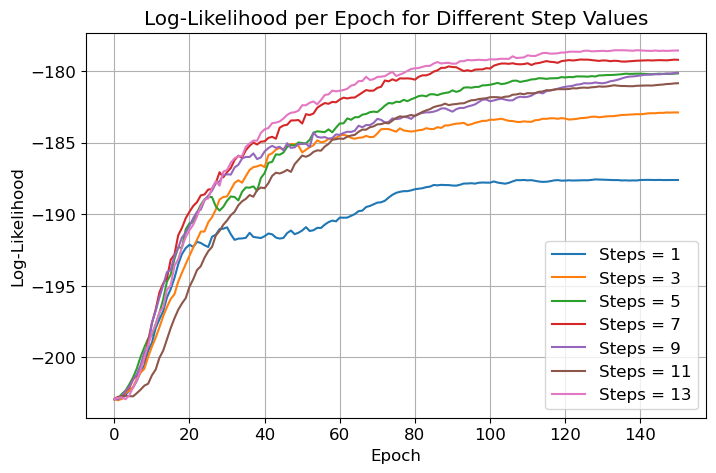

In [160]:
plot_log_likelihoods_per_epoch(log_likelihoods_per_step, Nepoch=150, filename="log_likelihood_steps.pdf")

## Test generative power of the trained RBM

In [ ]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

In [ ]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [ ]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

In [ ]:
Nd